In [0]:
%matplotlib inline


# Entrenar una Red para Clasificar Objetos a partir de imágenes:


Generalmente, cuando hay que lidiar con datos de imagen, texto, audio o video,
se suelen usar paquetes de Python que cargan datos en una matriz Numpy.

Para este ejemplo, transformaremos esta matriz de Numpy en una de Torch usando: ``. * Tensor``.

- Para imágenes, paquetes como Pillow, OpenCV son útiles.
- Para audio, paquetes como scipy y librosa.
- Para texto, paquetes de la libreria estandar de Python o Cython, o NLTK y
   SpaCy son útiles

En este caso, para la carga de imágenes, vamos a usar el paquete llamado
`` torchvision``, que simplifica la carga de datasets libres como Imagenet, CIFAR10, MNIST, etc. y transformadores de datos para imágenes, a saber,
`` torchvision.datasets`` y `` torch.utils.data.DataLoader``.

Esto proporciona una gran comodidad y evita escribir código.

Para este tutorial, usaremos el conjunto de datos CIFAR10. Tiene las clases: "avión", "automóvil", "pájaro", "gato", "venado", "Perro", "rana", "caballo", "barco", "camión". Las imágenes en CIFAR-10 son de tamaño 3x32x32, es decir, imágenes en color de 3 canales de 32x32 píxeles de tamaño, por ejemplo:

![texto alternativo](https://i.imgur.com/ihdlkR0.png/)


Una vez tenemos los datos, entrenaremos una red neuronal. Haremos los siguientes pasos en orden:

1. Carguar y normalizar los conjuntos de datos de prueba y entrenamiento CIFAR10 usando
    `` torchvision``
2. Definir una red neuronal de convolución
3. Definir una función de pérdida
4. Capacitar a la red en los datos de entrenamiento
5. Probar la red en los datos de prueba

## Cargando y normalizando CIFAR10.
Usando `` torchvision``, es extremadamente fácil cargar CIFAR10.



In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

La salida de los datasets de torchvision son imágenes de PILImage de rango [0, 1].




Los transformamos a Tensores de rango normalizado [-1, 1].



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

170500096it [00:06, 26198851.99it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Vamos a ver el aspecto que tiene una imagen:



 deer  frog  bird  deer


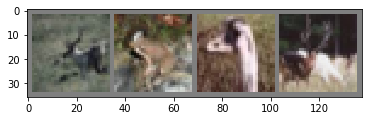

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Definir una red convolucional:
Vamos a definir una arquitectura de red con 2 [capas convolucionales](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/) con MaxPooling y 2 capas [fully connected](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.33725&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false):



In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Definir la función de pérdida y el optimizador
Como función de pérdida Classification Cross-Entropy loss y como optimizador: SGD con momentum.



In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Entrenar la red

Pasemos a entrenar la red:



In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.210
[1,  4000] loss: 1.846
[1,  6000] loss: 1.673
[1,  8000] loss: 1.589
[1, 10000] loss: 1.508
[1, 12000] loss: 1.458
[2,  2000] loss: 1.391
[2,  4000] loss: 1.379
[2,  6000] loss: 1.354
[2,  8000] loss: 1.323
[2, 10000] loss: 1.295
[2, 12000] loss: 1.292
Finished Training


## Validar la red
Hemos entrenado la red con dos pasadas sobre el dataset de entrenamiento, pero ahora necesitamos comprobar como funciona nuestra red sobre unos datos nuevos.

Vamos a chequear las predicciones de nuestra red contra las imágenes correctamente clasificadas. 

Dicho lo cual, vamos imprimir unas cuantas imágenes:



GroundTruth:   frog  frog   car  frog


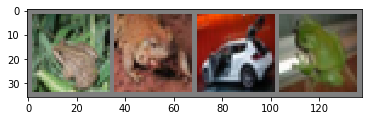

In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Bien, vamos a ver como etiqueta esas imagenes nuestra red:



In [0]:
outputs = net(images)

Las salidas son scores para las 10 clases. Cuanto más alta es el score para una clase, más piensa la red que la imagen es de la clase particular. Entonces, vamos a obtener el índice que maximiza el score:



In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog  frog truck  frog


Los resultados parecen bastante buenos.

Vamos a ver que tal lo hace para todo el dataset:


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


Puesto que la probabilidad media para acertar en el azar es de un 10%, nuestra red parece que lo hace bastante bien porque acierta un 53% de las veces!

En particular, ¿como lo hace para cada una de las clases?



In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 60 %
Accuracy of   car : 34 %
Accuracy of  bird : 37 %
Accuracy of   cat : 31 %
Accuracy of  deer : 50 %
Accuracy of   dog : 61 %
Accuracy of  frog : 51 %
Accuracy of horse : 60 %
Accuracy of  ship : 64 %
Accuracy of truck : 80 %
